In [4]:
library(circlize)
library(ComplexHeatmap)
library(data.table)

In [2]:
trans_dir = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_B_IN_tophits_multianno/"
trans_files = paste0(trans_dir,list.files(trans_dir))
head(trans_files,2)

[1] "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_B_IN_tophits_multianno/A1BG_B_IN_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt"
[2] "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_B_IN_tophits_multianno/AAAS_B_IN_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt"

In [3]:
gene_locs_file = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/GeneLocations.tsv"
gene_loc = fread(gene_locs_file)
head(gene_loc)

gene_name,gene_id,seqid,start,end,strand
<chr>,<chr>,<chr>,<int>,<int>,<chr>
AL627309.1,ENSG00000237683,1,134901,139379,-
AL669831.1,ENSG00000269831,1,738532,739137,-
AL645608.2,ENSG00000269308,1,818043,819983,+
AL645608.1,ENSG00000268179,1,861264,866445,-
AL645728.1,ENSG00000215014,1,1510355,1511373,+
AL590822.2,ENSG00000269554,1,2121237,2123179,+


In [6]:
gene_files = list.files(paste0(trans_dir,"merged_p5e_8/"), pattern=".merged.txt")
length(gene_files)
head(gene_files,2)

[1] 908

[1] "ABCA1_B_IN_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt"
[2] "ABHD3_B_IN_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt"

In [7]:
genes = gsub("_B_IN_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt", "", gene_files)
length(genes)
head(genes)

[1] 908

[1] "ABCA1"      "ABHD3"      "ABRACL"     "AC000003.2" "AC002480.2"
[6] "AC004951.6"

In [8]:
GC_lambda_file = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/B_IN_trans_GClambda.txt"
gcl_df = as.data.frame(fread(GC_lambda_file))
colnames(gcl_df) = c("gene", paste0("pcl",c(0.7,0.5,0.1,0.01,0.001)))
head(gcl_df,2)
remove_genes_gcl = gcl_df[gcl_df$pcl0.5>1.05,"gene"]
remove_genes_gcl

,gene,pcl0.7,pcl0.5,pcl0.1,pcl0.01,pcl0.001
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG,0.967,0.967,0.957,0.941,0.959
2,AAAS,0.942,0.946,0.942,0.944,0.925


[1] "RPL23A"

In [9]:
df_list = list()
for (i in 1:length(genes)){
    gene = genes[i]
    if (gene %in% remove_genes_gcl){next}
    chrom = gene_loc[gene_loc$gene_name == gene,"seqid"]$seqid[1]
    gene_start = gene_loc[gene_loc$gene_name == gene,"start"]$start[1]
    gene_end = gene_loc[gene_loc$gene_name == gene,"end"]$end[1]
    file = paste0(trans_dir,"merged/",gene_files[i])
    df = as.data.frame(fread(file))
    if (nrow(df)==0){next}
    colnames(df)[(ncol(df)-2):ncol(df)] <- c("p.value","neg.log10.p.value","cis.trans")
    # filter to genome-wide significance
    df = df[df$p.value < 5e-8,]
    if (nrow(df)==0){next}
    # remove HLA region (https://www.ncbi.nlm.nih.gov/grc/human/regions/MHC?asm=GRCh37)
    df = df[!(df$Chr==6 & df$Start >= 28477797 & df$Start <= 33448354),]
    if (nrow(df)==0){next}
    colnames(df)[1:5] <- paste0("snp_",colnames(df)[1:5])
    df$gene_chr = chrom
    df$gene_start = gene_start
    df$gene_end = gene_end
    df$window_start = max(0,min(gene_start, gene_end)-2000000)
    df$window_end = max(gene_start, gene_end)+2000000
    df$gene = gene
    df_list[[gene]] = df
}
df_combine = rbindlist(df_list)

In [10]:
nrow(df_combine)
head(df_combine)

[1] 357

snp_Chr,snp_Start,snp_End,snp_Ref,snp_Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,⋯,SiPhy_29way_logOdds,p.value,neg.log10.p.value,cis.trans,gene_chr,gene_start,gene_end,window_start,window_end,gene
<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>
17,10049841,10049841,T,C,intronic,GAS7,,NA,NA,⋯,NA,2.00036e-08,7.698892,known,17,10048831,10050277,8048831,12050277,AC000003.2
1,204388944,204388944,G,A,intergenic,PPP1R15B;PIK3C2B,dist=7999;dist=2821,NA,NA,⋯,NA,3.55113e-08,7.449633,potential_novel,7,22689579,22705152,20689579,24705152,AC002480.2
19,18660566,18660566,T,C,intergenic,FKBP8;KXD1,dist=6183;dist=8006,NA,NA,⋯,NA,1.17898e-09,8.928494,known,19,18668585,18672370,16668585,20672370,AC005253.2
16,74198061,74198061,C,T,intergenic,LINC01568;LOC101928035,dist=742766;dist=28230,NA,NA,⋯,NA,9.88070e-09,8.005212,known,16,74316313,74321417,72316313,76321417,AC009120.10
2,43449385,43449385,C,T,downstream,ZFP36L2,dist=156,NA,NA,⋯,NA,9.64338e-09,8.015771,known,2,43456712,43460533,41456712,45460533,AC010883.5
9,139611159,139611159,G,A,intronic,DIPK1B,,NA,NA,⋯,NA,1.13360e-20,19.945540,potential_novel,7,84568665,84569561,82568665,86569561,AC074183.4


In [11]:
# create a matrix, SNP chromosome by gene chromosome
mat=as.matrix(table(df_combine$snp_Chr, df_combine$gene_chr))
# add "chr" to chromosome names
rownames(mat) = paste0("chr",rownames(mat))
colnames(mat) = paste0("chr",colnames(mat))
# sort chromosomes from 1 to 22
mat = mat[paste0("chr",1:22),paste0("chr",1:22)]

In [12]:
max(mat)

[1] 21

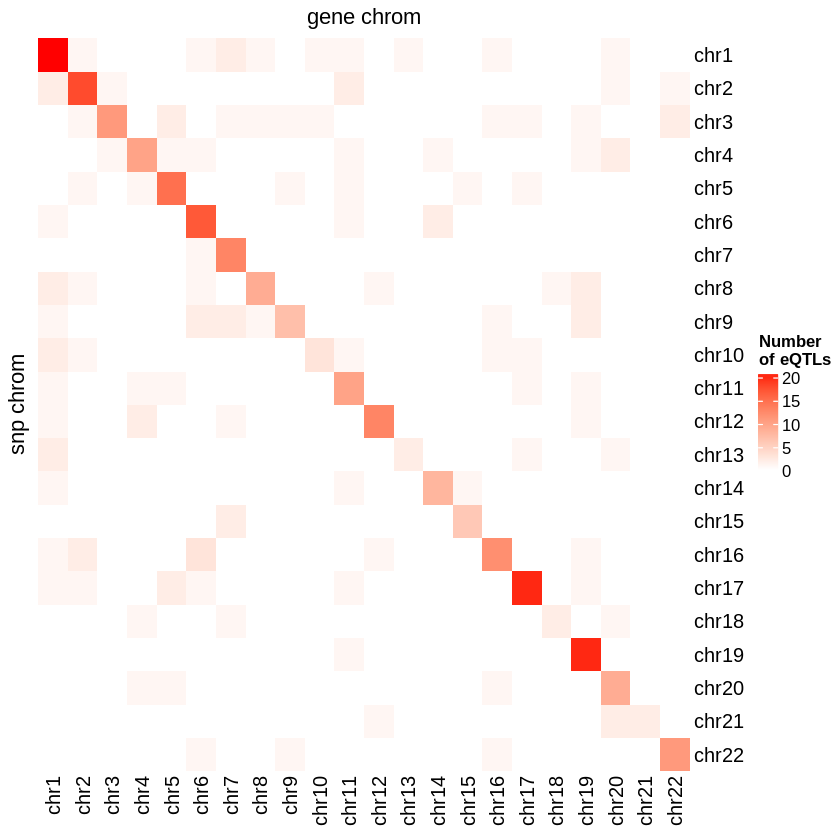

In [13]:
# all results (cis + trans)
col_fun = colorRamp2(c(0, max(mat)), c("white", "red"))
Heatmap(mat, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number \nof eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)

In [14]:
fig_dir <- "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/ms_figures/trans/"
pdf(paste0(fig_dir,"B_IN_trans_cis_heatmap_pv_5e_8.pdf"), width=10, height=10)
Heatmap(mat, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number \nof eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)
dev.off()

png 
  2

In [15]:
# trans only (different chromosome and or not within 2Mb of gene)
# df_combine_trans_only = df_combine[df_combine$cis.trans == "potential_novel"]
df_combine$cis.trans.2mb = "trans"
df_combine$snp_Chr = as.character(df_combine$snp_Chr)
df_combine[df_combine$gene_chr == df_combine$snp_Chr & df_combine$snp_Start >= df_combine$window_start & df_combine$snp_Start <= df_combine$window_end, "cis.trans.2mb"] = "cis"
table(df_combine$cis.trans.2mb)
df_combine_trans_only = df_combine[df_combine$cis.trans.2mb == "trans",]


  cis trans 
  233   124 

In [16]:
mat_trans=as.matrix(table(df_combine_trans_only$snp_Chr, df_combine_trans_only$gene_chr))
rownames(mat_trans)
colnames(mat_trans)

[1] "1"  "10" "11" "12" "13" "14" "15" "16" "17" "18" "19" "2"  "20" "21" "22"
[16] "3"  "4"  "5"  "6"  "7"  "8"  "9"

[1] "1"  "10" "11" "12" "13" "14" "15" "16" "17" "18" "19" "2"  "20" "22" "3" 
[16] "4"  "5"  "6"  "7"  "8"  "9"

In [17]:
rownames(mat_trans) = paste0("chr",rownames(mat_trans))
colnames(mat_trans) = paste0("chr",colnames(mat_trans))
mat_trans = mat_trans[paste0("chr",c(1:22)),paste0("chr",c(1:20,22))]

In [18]:
max(mat_trans)

[1] 3

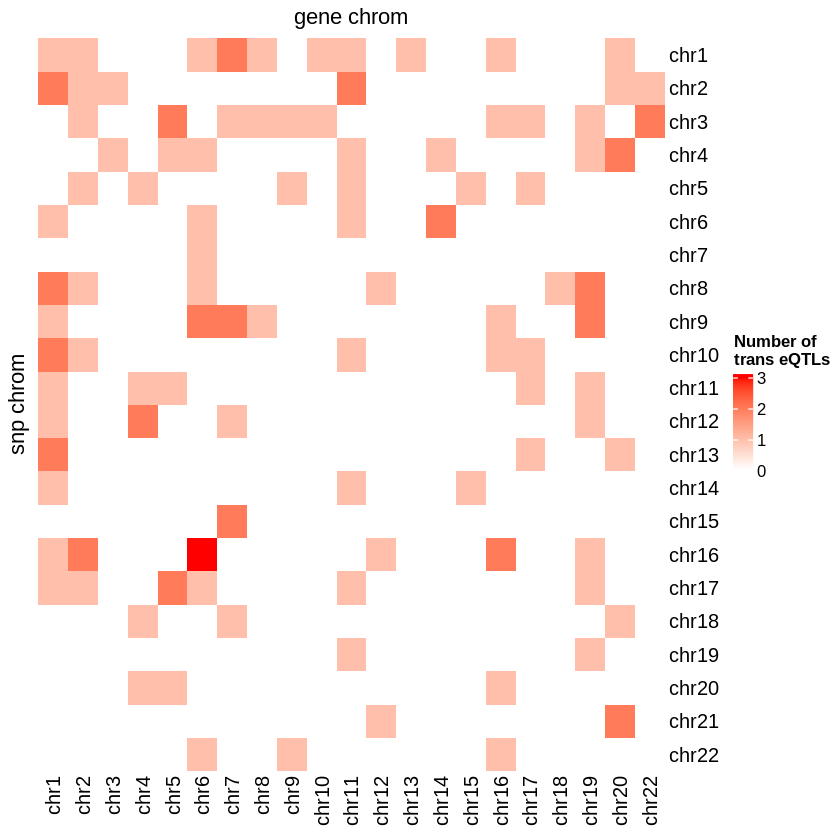

In [19]:
col_fun = colorRamp2(c(0, max(mat_trans)), c("white", "red"))
Heatmap(mat_trans, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number of \ntrans eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)

In [20]:
fig_dir <- "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/ms_figures/trans/"
pdf(paste0(fig_dir,"B_IN_trans_only_heatmap_pv_5e_8.pdf"), width=10, height=10)
Heatmap(mat_trans, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number of \ntrans eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)
dev.off()

png 
  2

In [21]:
nrow(df_combine_trans_only)

[1] 124

In [22]:
fwrite(df_combine_trans_only, "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/for_wei/trans/B_IN_trans_eqtls_p5e_8.txt")